# Skin Cancer Classification using ISIC 2019 Dataset
This notebook explores the ISIC 2019 dataset to classify different types of skin cancer. The workflow includes:
- **Data exploration and preprocessing**
- **Feature extraction using ResNet50**
- **Training multiple ML models**
- **Comparing performance using accuracy & confusion matrix**
- **Implementing a sample prediction system**

## Dataset Overview
The ISIC 2019 dataset contains images of skin lesions categorized into different skin cancer types. We will analyze and classify these images using  machine learning models.
The data contained 25000 images of skin lesions classified with 9 following classes ranging from benign to malignant skin cancer:

- NV (Nevus): This category has the highest number of images, with over 12,000 images, represented by the tallest bar.
- MEL (Melanoma): The second-largest group with around 4,000 images.
- BCC (Basal Cell Carcinoma): This category contains around 3,000 images.
- BKL (Benign Keratosis-like lesions): This category has fewer images, just above 2,000.
- AK (Actinic Keratosis): This is a smaller category, with fewer than 1,000 images.
- DF (Dermatofibroma): This category also has fewer images.
- VASC (Vascular lesions): Represented by a smaller bar, indicating fewer images.
- SCC (Squamous Cell Carcinoma): This is another small group with very few images.
- UNK (Unknown): This category represents unknown or uncategorized images and is also small in terms of the number of images.



# 📂 Load and Explore Dataset
We will load:
- **Metadata file**: Contains information about images.
- **Ground truth labels**: Multi-class classification labels.
- **Image files**: Actual skin lesion images.


In [1]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.models as models
#import timm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
from sklearn.utils import resample


Metadata Sample:


,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male



Ground Truth Sample:


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


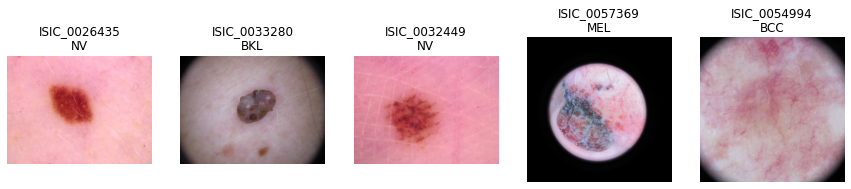

In [2]:
metadata_path = "/kaggle/input/isic-2019/ISIC_2019_Training_Metadata.csv"
groundtruth_path = "/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv"
image_dir = "/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input"
metadata_df = pd.read_csv(metadata_path)
groundtruth_df = pd.read_csv(groundtruth_path)

print("Metadata Sample:")
display(metadata_df.head())

print("\nGround Truth Sample:")
display(groundtruth_df.head())

def display_sample_images(image_list, image_dir, groundtruth_df, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, img_name in enumerate(image_list[:num_images]):
        img_path = os.path.join(image_dir, img_name + ".jpg")

        if not os.path.exists(img_path):
            print(f"Warning: Image {img_name}.jpg not found!")
            axes[i].set_title("Image Not Found")
            axes[i].axis("off")
            continue

        img = cv2.imread(img_path)

        if img is None:
            print(f"Error: Failed to load {img_name}.jpg")
            axes[i].set_title("Load Error")
            axes[i].axis("off")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        row = groundtruth_df[groundtruth_df['image'] == img_name].iloc[:, 1:]
        cancer_type = row.columns[row.values.argmax()]

        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"{img_name}\n{cancer_type}")

    plt.show()

sample_images = groundtruth_df.sample(5)['image'].values
display_sample_images(sample_images, image_dir, groundtruth_df)


# 📊 Class Distribution
We will visualize the class distribution to understand the imbalance in the dataset.

The graph shows the class distribution of images in the ISIC 2019 dataset, which is used for skin cancer classification. The x-axis represents different types of skin cancer or lesions, while the y-axis shows the number of images corresponding to each category.

Here's a breakdown of the categories and the number of images for each:

- NV (Nevus): This category has the highest number of images, with over 12,000 images, represented by the tallest bar.
- MEL (Melanoma): The second-largest group with around 4,000 images.
- BCC (Basal Cell Carcinoma): This category contains around 3,000 images.
- BKL (Benign Keratosis-like lesions): This category has fewer images, just above 2,000.
- AK (Actinic Keratosis): This is a smaller category, with fewer than 1,000 images.
- DF (Dermatofibroma): This category also has fewer images.
- VASC (Vascular lesions): Represented by a smaller bar, indicating fewer images.
- SCC (Squamous Cell Carcinoma): This is another small group with very few images.
- UNK (Unknown): This category represents unknown or uncategorized images and is also small in terms of the number of images.
  
In summary, the dataset is heavily imbalanced, with the "NV" category having significantly more images compared to the other categories. This imbalance might need to be addressed when training machine learning models for skin cancer classification.


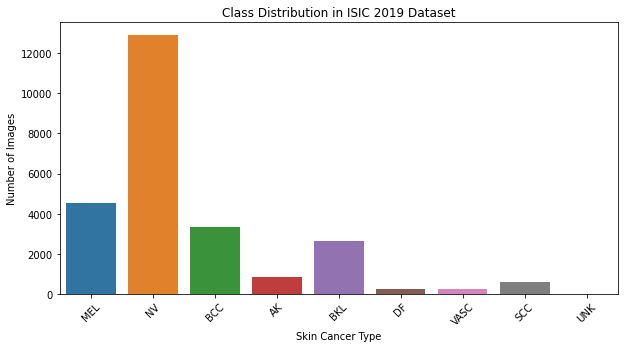

In [3]:
class_counts = groundtruth_df.iloc[:, 1:].sum()
plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xticks(rotation=45)
plt.xlabel("Skin Cancer Type")
plt.ylabel("Number of Images")
plt.title("Class Distribution in ISIC 2019 Dataset")
plt.show()


# ⚖️ Handling Class Imbalance in ISIC 2019 Dataset
The dataset is highly **imbalanced**, with some classes containing significantly more images than others. Training a model on an imbalanced dataset can lead to biased predictions.

### 🛠 Methods to Balance Data:
1. **Undersampling**: Reducing the number of samples in the majority class.
2. **Oversampling**: Duplicating samples from minority classes.


Since **undersampling** removes valuable data, we will use **oversampling** by duplicating images from underrepresented classes to match the majority class.


Skipping class 'UNK' because it has no samples.
Balanced Class Distribution:
 MEL     12875.0
NV      12875.0
BCC     12875.0
AK      12875.0
BKL     12875.0
DF      12875.0
VASC    12875.0
SCC     12875.0
UNK         0.0
dtype: float64


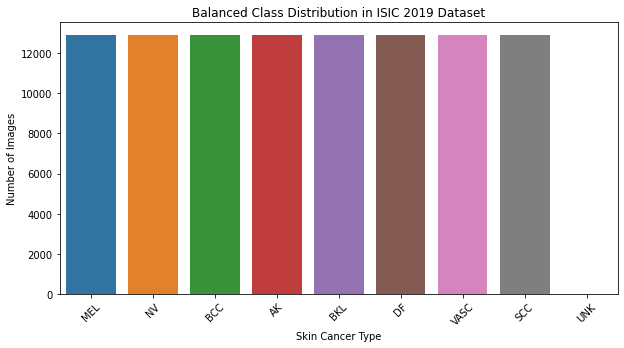

In [4]:
balanced_data = []

max_count = int(groundtruth_df.iloc[:, 1:].sum().max())

for class_name in groundtruth_df.columns[1:]:
    class_subset = groundtruth_df[groundtruth_df[class_name] == 1]

    if len(class_subset) == 0:
        print(f"Skipping class '{class_name}' because it has no samples.")
        continue

    class_upsampled = resample(class_subset, replace=True, n_samples=max_count, random_state=42)

    balanced_data.append(class_upsampled)

balanced_groundtruth_df = pd.concat(balanced_data)

balanced_groundtruth_df = balanced_groundtruth_df.sample(frac=1, random_state=42).reset_index(drop=True)

balanced_class_counts = balanced_groundtruth_df.iloc[:, 1:].sum()
print("Balanced Class Distribution:\n", balanced_class_counts)

plt.figure(figsize=(10, 5))
sns.barplot(x=balanced_class_counts.index, y=balanced_class_counts.values)
plt.xticks(rotation=45)
plt.xlabel("Skin Cancer Type")
plt.ylabel("Number of Images")
plt.title("Balanced Class Distribution in ISIC 2019 Dataset")
plt.show()


*After doing oversampling of minority class we can see from above grpah that all classes have equal representation in the data now*

# 🔍 Feature Extraction using EfficientNet-B3

We will extract **deep learning embeddings** using a pre-trained **EfficientNet-B3** model.


In [15]:
# upgrade pip tooling
!pip install -U pip setuptools wheel -q

# install timm without pulling any extra/transitive deps (torch is preinstalled on Kaggle)
!pip install --no-deps timm -q

# verify
import timm, torch
print("timm:", timm.__version__)
print("torch:", torch.__version__)


DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
timm: 0.9.12
torch: 1.11.0


In [16]:

image_dir = "/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input"

#  Define image preprocessing for EfficientNet-B3
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#  Load Pretrained Model (EfficientNet-B3) and Modify to Output 512D
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model("efficientnet_b3", pretrained=True)

#  Modify the classifier head to output **512D embeddings**
model.classifier = torch.nn.Linear(model.classifier.in_features, 512)
model = model.to(device)
model.eval()

image_files = []

# Scan and filter valid image files
for file in tqdm(os.listdir(image_dir), desc="Scanning Files", unit="file"):
    if file.endswith(".jpg") or file.endswith(".png"):
        image_files.append(file)  # Store valid image files

# Process images and extract embeddings
embeddings = []
image_names = []

for img_file in tqdm(image_files, desc="Extracting Embeddings", unit="image"):
    img_path = os.path.join(image_dir, img_file)
    image = Image.open(img_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    # Extract embedding
    with torch.no_grad():
        embedding = model(image).cpu().numpy().flatten()  # Now 512D

    # Store image name and embedding separately
    image_names.append(os.path.splitext(img_file)[0])  # Store name without extension
    embeddings.append(embedding)  # Store embedding as list

#  Convert to DataFrame (Expanded Format)
df = pd.DataFrame(embeddings)
df.columns = [str(i) for i in range(512)]
df.insert(0, "image_name", image_names)

df.to_csv("image_embeddings_efficientnet_b3.csv", index=False)

print("✅ Embeddings extracted and saved to image_embeddings_efficientnet_b3.csv")


Downloading:   0%|          | 0.00/49.5M [00:00<?, ?B/s]

Extracting Embeddings: 100%|██████████| 25331/25331 [25:04<00:00, 16.84image/s]


✅ Embeddings extracted and saved to image_embeddings_efficientnet_b3.csv


In [17]:
#pd.read_csv('/kaggle/input/image-embeddings-resnet/image_embeddings_expanded (1).csv')
pd.read_csv('image_embeddings_efficientnet_b3.csv')


,image_name,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,ISIC_0057312,-0.034804,0.029379,-0.040044,0.229864,0.085703,0.001785,-0.027221,0.168948,-0.146512,...,0.152524,0.331035,-0.251711,-0.164940,-0.066777,0.113477,-0.312472,-0.063369,0.268630,-0.157262
1,ISIC_0014233_downsampled,-0.086832,0.161763,-0.288836,-0.001434,0.296324,0.072003,0.108609,0.165551,0.016203,...,-0.171324,0.230591,0.095338,0.226261,-0.086647,0.043738,-0.142371,0.118648,0.236320,-0.004217
2,ISIC_0059626,-0.145388,0.139490,0.058518,-0.159605,-0.129523,0.303640,-0.072874,0.022211,0.017457,...,0.042553,0.132655,-0.124828,-0.143730,0.014410,-0.297809,-0.177323,0.096149,0.005287,-0.369404
3,ISIC_0056156,-0.018564,-0.244943,-0.202147,0.136601,-0.050232,0.147412,-0.066571,0.268565,-0.079177,...,0.175688,0.575894,0.073327,-0.195162,0.024866,0.217182,-0.193572,-0.031399,0.401935,-0.227902
4,ISIC_0030912,-0.094411,0.108913,-0.097770,-0.031519,0.042076,0.026822,0.082338,-0.010502,-0.121600,...,0.102131,0.196751,-0.256792,-0.132877,-0.165846,-0.020779,-0.329258,0.213043,0.143782,-0.231300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0010257,0.236628,-0.016470,-0.107597,0.097822,-0.169267,0.084376,-0.012176,0.138644,0.187295,...,0.002463,0.291862,0.033886,-0.061703,-0.067264,-0.208084,-0.235061,0.145535,0.200460,-0.103961
25327,ISIC_0012539_downsampled,-0.052469,-0.094032,-0.101357,0.171294,-0.138430,0.045409,0.104286,0.036049,-0.048431,...,0.042503,0.063456,0.027392,0.024797,-0.040346,0.125579,-0.166207,0.075159,0.298736,-0.132621
25328,ISIC_0026236,-0.065854,-0.077722,0.017761,0.168764,-0.117338,0.071118,-0.003625,0.015322,-0.128030,...,0.196265,0.187626,0.038579,-0.063165,-0.076865,-0.008478,-0.120965,-0.122816,0.189157,-0.126472
25329,ISIC_0030344,-0.225922,0.002282,0.003098,0.017552,-0.095535,0.069727,-0.127675,0.079188,0.104911,...,-0.103611,0.110895,-0.191225,-0.043609,-0.160089,-0.112721,-0.056231,-0.088918,-0.017614,-0.139260


Embeddings extracted from ResNet models are high-dimensional vectors representing an image's features after passing through the network. These embeddings capture essential patterns and structures, condensing the image into a fixed-size vector. They are useful for tasks like image similarity, retrieval, and transfer learning.

# Merging ISIC 2019 Dataset: Ground Truth, Embeddings, and Metadata

## **Overview**
This script merges three datasets related to the **ISIC 2019 skin lesion classification challenge**:
1. **Ground Truth Labels** (`ISIC_2019_Training_GroundTruth.csv`)
2. **Extracted Image Embeddings** (`image_embeddings_expanded.csv`)
3. **Metadata Information** (`ISIC_2019_Training_Metadata.csv`)

In [19]:
df_gt = pd.read_csv('/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv')
df_emb = pd.read_csv('image_embeddings_efficientnet_b3.csv')
df_meta = pd.read_csv('/kaggle/input/isic-2019/ISIC_2019_Training_Metadata.csv')
df_emb.rename(columns={"image_name": "image"}, inplace=True)

#  Perform INNER JOIN on 'image' across all DataFrames
df_merged = df_gt.merge(df_emb, on="image", how="inner").merge(df_meta, on="image", how="inner")
df_merged.to_csv("/kaggle/working/isic_2019_merged.csv", index=False)

print("✅ Merging complete! Saved as isic_2019_merged.csv")

✅ Merging complete! Saved as isic_2019_merged.csv


In [20]:
#df = pd.read_csv('/kaggle/input/isic-merged/isic_2019_merged.csv')
df = pd.read_csv('/kaggle/working/isic_2019_merged.csv')

df.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (524) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,...,506,507,508,509,510,511,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.103746,-0.042400,-0.099601,-0.065830,0.023401,-0.021417,55.0,anterior torso,NaN,female
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.085722,-0.142407,-0.181174,0.144738,0.117598,-0.077886,30.0,anterior torso,NaN,female
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.039990,0.313054,-0.282661,-0.068812,0.158350,-0.064553,60.0,upper extremity,NaN,female
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.026060,0.029068,0.059678,0.102032,0.125756,-0.075398,30.0,upper extremity,NaN,male
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.175264,0.288897,-0.449186,-0.207912,0.120992,-0.166388,80.0,posterior torso,NaN,male


# ISIC 2019 Data Preprocessing

## **Overview**
This script processes the **ISIC 2019 dataset** and prepares it for machine learning models. It includes:
# Data cleaning & preprocessing
- Drop Unnecessary Columns
- Handle Missing Values in 'sex' Column
- One-Hot Encoding for 'anatom_site_general' Column
- Convert One-Hot Encoded Labels to Single Target Class
- Handle Missing Values in Features (X)
- Standardize Features

In [21]:
file_path = "/kaggle/working/isic_2019_merged.csv"

df = pd.read_csv(file_path, low_memory=False)

df = df.drop(columns=['image', 'lesion_id'])

df['sex'] = df['sex'].fillna('unknown')
encoder = LabelEncoder()
df['sex'] = encoder.fit_transform(df['sex'])

df = pd.get_dummies(df, columns=['anatom_site_general'], drop_first=True)

X = df.drop(df.columns[:9], axis=1)
Y = df.iloc[:, :9]
print(Y)

Y = Y.idxmax(axis=1)

imputer = SimpleImputer(strategy="mean")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


       MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0      0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1      0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2      1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3      0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4      1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
...    ...  ...  ...  ...  ...  ...   ...  ...  ...
25326  0.0  0.0  1.0  0.0  0.0  0.0   0.0  0.0  0.0
25327  0.0  0.0  0.0  0.0  1.0  0.0   0.0  0.0  0.0
25328  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
25329  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
25330  0.0  0.0  0.0  0.0  1.0  0.0   0.0  0.0  0.0

[25331 rows x 9 columns]


### Logistic Regression Model

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.22803489
Epoch 3, change: 0.17674920
Epoch 4, change: 0.16777572
Epoch 5, change: 0.08300147
Epoch 6, change: 0.07295852
Epoch 7, change: 0.26743745
Epoch 8, change: 0.17033222
Epoch 9, change: 0.14312499
Epoch 10, change: 0.13217446
Epoch 11, change: 0.09264278
Epoch 12, change: 0.08250090
Epoch 13, change: 0.07761609
Epoch 14, change: 0.06250535
Epoch 15, change: 0.09379638
Epoch 16, change: 0.09843917
Epoch 17, change: 0.04229788
Epoch 18, change: 0.04749448
Epoch 19, change: 0.05359826
Epoch 20, change: 0.04847676
Epoch 21, change: 0.04434174
Epoch 22, change: 0.04876416
Epoch 23, change: 0.05154674
Epoch 24, change: 0.04304568
Epoch 25, change: 0.04804403
Epoch 26, change: 0.04319553
Epoch 27, change: 0.04955395
Epoch 28, change: 0.04810036
Epoch 29, change: 0.05436391
Epoch 30, change: 0.04015204
Epoch 31, change: 0.04837185
Epoch 32, change: 0.05606795
Epoch 33, change: 0.04858164
Epoch 34, change: 0.03665261
Epoch 35, change: 0.042

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 14.1min finished


              precision    recall  f1-score   support

          AK     0.2848    0.4972    0.3621       177
         BCC     0.6187    0.5745    0.5957       658
         BKL     0.4250    0.4757    0.4489       536
          DF     0.1591    0.4375    0.2333        48
         MEL     0.5657    0.5738    0.5697       915
          NV     0.8962    0.7398    0.8105      2567
         SCC     0.1966    0.5577    0.2907       104
        VASC     0.4658    0.5484    0.5037        62

    accuracy                         0.6430      5067
   macro avg     0.4515    0.5506    0.4769      5067
weighted avg     0.7027    0.6430    0.6653      5067



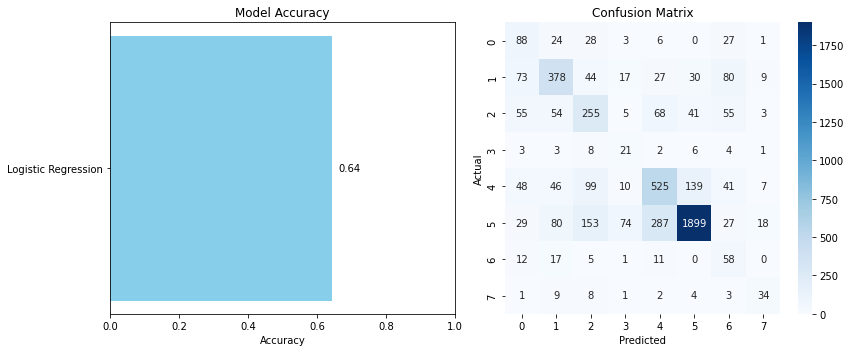

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train Logistic Regression model
log_reg = LogisticRegression(max_iter=2000, solver='saga', penalty='l2',
                             class_weight="balanced", verbose=1)
log_reg.fit(X_train_scaled, Y_train)

# Predictions
Y_pred = log_reg.predict(X_test_scaled)

# Accuracy
accuracy_log_reg = accuracy_score(Y_test, Y_pred)

# Print results
print(f"Logistic Regression Accuracy: {accuracy_log_reg:.4f}\n")
print("Classification Report:")
print(classification_report(Y_test, Y_pred, digits=4))

# ---------- Better Visualization ----------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 1. Horizontal Accuracy Bar
ax[0].barh(['Logistic Regression'], [accuracy_log_reg], color='skyblue')
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Accuracy")
ax[0].set_title("Model Accuracy")
for i, v in enumerate([accuracy_log_reg]):
    ax[0].text(v + 0.02, i, f"{v:.2f}", va='center')

# 2. Confusion Matrix Heatmap
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[1])
ax[1].set_title("Confusion Matrix")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


***Logistic Regression Model accuracy is 0.6430***

### Support Vector Machine (SVM) Model

SVM Model Accuracy: 0.7509

Classification Report:
              precision    recall  f1-score   support

          AK     0.5556    0.2542    0.3488       177
         BCC     0.6138    0.7994    0.6944       658
         BKL     0.6751    0.5000    0.5745       536
          DF     0.0000    0.0000    0.0000        48
         MEL     0.7186    0.5694    0.6354       915
          NV     0.8133    0.9400    0.8721      2567
         SCC     0.6957    0.1538    0.2520       104
        VASC     0.9412    0.2581    0.4051        62

    accuracy                         0.7509      5067
   macro avg     0.6266    0.4344    0.4728      5067
weighted avg     0.7381    0.7509    0.7298      5067



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM model saved as 'svm_model.pkl' successfully!


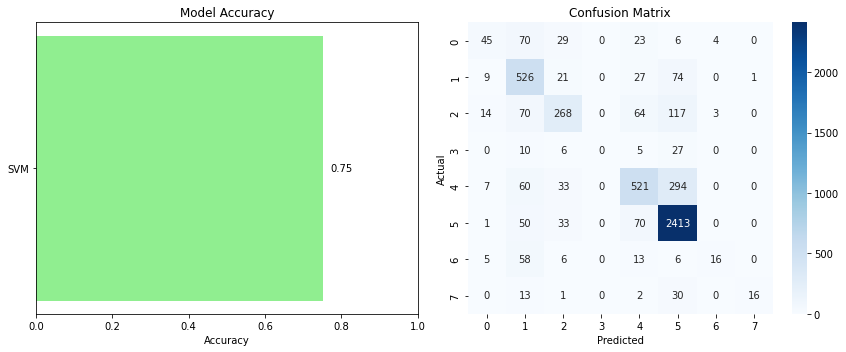

In [23]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC

# Train SVM model
svm_model = SVC(kernel='rbf', C=1, gamma='scale')
svm_model.fit(X_train_scaled, Y_train)

# Predictions
Y_pred_svm = svm_model.predict(X_test_scaled)

# Accuracy
accuracy_svm = accuracy_score(Y_test, Y_pred_svm)
print(f"SVM Model Accuracy: {accuracy_svm:.4f}\n")
print("Classification Report:")
print(classification_report(Y_test, Y_pred_svm, digits=4))

# Save the trained model
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)
print("SVM model saved as 'svm_model.pkl' successfully!")

# ---------- Better Visualization ----------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 1. Horizontal Accuracy Bar
ax[0].barh(['SVM'], [accuracy_svm], color='lightgreen')
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Accuracy")
ax[0].set_title("Model Accuracy")
ax[0].text(accuracy_svm + 0.02, 0, f"{accuracy_svm:.2f}", va='center')

# 2. Confusion Matrix Heatmap
cm = confusion_matrix(Y_test, Y_pred_svm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[1])
ax[1].set_title("Confusion Matrix")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


***SVM Model accuracy is 0.7509***

### LIGHTGBM (Tree-based, so no need for feature scaling)

LightGBM Model Accuracy: 0.7117

Classification Report:
              precision    recall  f1-score   support

          AK     0.5875    0.2655    0.3658       177
         BCC     0.5937    0.6839    0.6356       658
         BKL     0.6000    0.3694    0.4573       536
          DF     0.5000    0.0208    0.0400        48
         MEL     0.6394    0.5290    0.5789       915
          NV     0.7737    0.9349    0.8467      2567
         SCC     0.6552    0.1827    0.2857       104
        VASC     0.7778    0.1129    0.1972        62

    accuracy                         0.7117      5067
   macro avg     0.6409    0.3874    0.4259      5067
weighted avg     0.6962    0.7117    0.6858      5067

LightGBM model saved as 'lgbm_model.pkl' successfully!


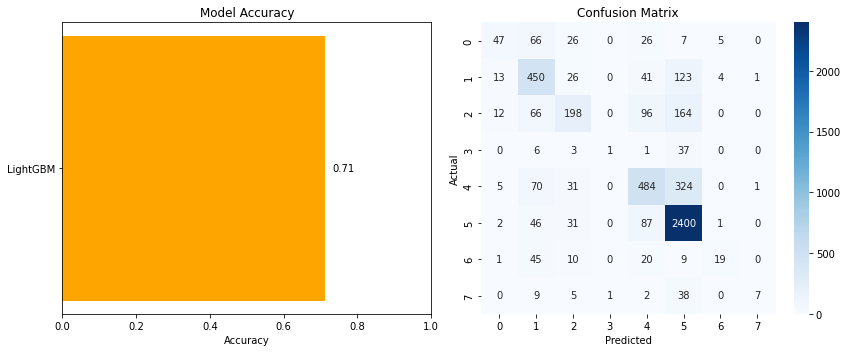

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train LightGBM model
lgbm_model = LGBMClassifier(n_estimators=100, learning_rate=0.05, is_unbalance=True)
lgbm_model.fit(X_train_scaled, Y_train)

# Predictions
Y_pred_lgbm = lgbm_model.predict(X_test_scaled)

# Accuracy
accuracy_lgbm = accuracy_score(Y_test, Y_pred_lgbm)
print(f"LightGBM Model Accuracy: {accuracy_lgbm:.4f}\n")
print("Classification Report:")
print(classification_report(Y_test, Y_pred_lgbm, digits=4))

# Save the trained model
with open('lgbm_model.pkl', 'wb') as f:
    pickle.dump(lgbm_model, f)
print("LightGBM model saved as 'lgbm_model.pkl' successfully!")

# ---------- Better Visualization ----------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 1. Horizontal Accuracy Bar
ax[0].barh(['LightGBM'], [accuracy_lgbm], color='orange')
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Accuracy")
ax[0].set_title("Model Accuracy")
ax[0].text(accuracy_lgbm + 0.02, 0, f"{accuracy_lgbm:.2f}", va='center')

# 2. Confusion Matrix Heatmap
cm = confusion_matrix(Y_test, Y_pred_lgbm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[1])
ax[1].set_title("Confusion Matrix")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()



HistGradientBoosting Accuracy: 0.7397

Classification Report:
              precision    recall  f1-score   support

          AK     0.6914    0.3164    0.4341       177
         BCC     0.6299    0.7112    0.6681       658
         BKL     0.6096    0.4515    0.5188       536
          DF     1.0000    0.0625    0.1176        48
         MEL     0.6823    0.5869    0.6310       915
          NV     0.8010    0.9408    0.8653      2567
         SCC     0.6061    0.1923    0.2920       104
        VASC     0.8750    0.1129    0.2000        62

    accuracy                         0.7397      5067
   macro avg     0.7369    0.4218    0.4659      5067
weighted avg     0.7321    0.7397    0.7187      5067

Model saved as 'hist_gb_model.pkl'


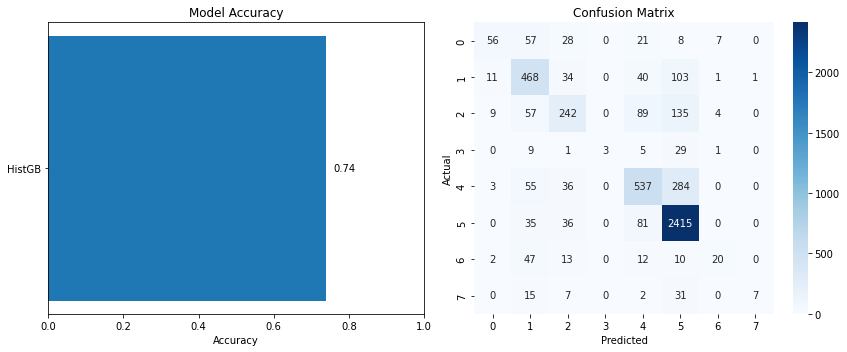

In [25]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# =========================
# FAST HistGradientBoosting
# =========================
# Tip: tree models don't need scaling, but using your X_train_scaled/X_test_scaled is fine.
Xtr = X_train_scaled.astype(np.float32)
Xte = X_test_scaled.astype(np.float32)
ytr = Y_train
yte = Y_test

hgb = HistGradientBoostingClassifier(
    max_iter=600,            # upper bound; early_stopping will stop earlier
    learning_rate=0.06,      # slightly higher LR -> fewer trees needed
    max_leaf_nodes=31,       # controls complexity (like depth)
    min_samples_leaf=20,     # regularization
    l2_regularization=1.0,   # regularization
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=30,     # stop when no improvement
    random_state=42
)

hgb.fit(Xtr, ytr)

# -------------------------
# Predictions & Metrics
# -------------------------
y_pred = hgb.predict(Xte)
acc = accuracy_score(yte, y_pred)

print(f"HistGradientBoosting Accuracy: {acc:.4f}\n")
print("Classification Report:")
print(classification_report(yte, y_pred, digits=4))

# -------------------------
# Save the trained model
# -------------------------
with open('hist_gb_model.pkl', 'wb') as f:
    pickle.dump(hgb, f)
print("Model saved as 'hist_gb_model.pkl'")

# -------------------------
# Visualizations
# -------------------------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 1) Horizontal Accuracy Bar
ax[0].barh(['HistGB'], [acc])
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Accuracy")
ax[0].set_title("Model Accuracy")
ax[0].text(min(acc + 0.02, 0.98), 0, f"{acc:.2f}", va='center')

# 2) Confusion Matrix Heatmap
cm = confusion_matrix(yte, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[1])
ax[1].set_title("Confusion Matrix")
ax[1].set_xlabel("Predicted"); ax[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# -------------------------
# Optional: ROC-AUC (binary)
# -------------------------
if len(np.unique(yte)) == 2:
    y_prob = hgb.predict_proba(Xte)[:, 1]
    auc = roc_auc_score(yte, y_prob)
    fpr, tpr, _ = roc_curve(yte, y_prob)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve — HistGradientBoosting")
    plt.legend()
    plt.show()


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



🔍 **Predicted Class for the Sample (SVM):** NV


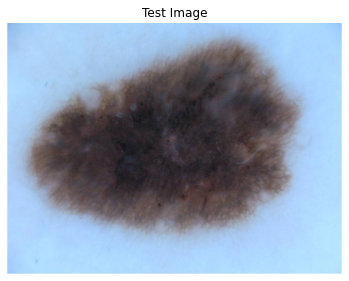

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model("efficientnet_b3", pretrained=True)
model.classifier = torch.nn.Linear(model.classifier.in_features, 512)  # 512D output
model = model.to(device)
model.eval()
#code prompt : Write a Python function to preprocess images, resize them, normalize the pixel values, and extract 512-dimensional embeddings using a modified EfficientNet-B3 model.
# Define image preprocessing.
transform = transforms.Compose([
    transforms.Resize((300, 300)),  # EfficientNet-B3 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# Load the merged training data to get feature names.
train_file = "/kaggle/working/isic_2019_merged.csv"
df_train = pd.read_csv(train_file, low_memory=False)

# Drop columns not used as features.
df_train = df_train.drop(columns=['image', 'lesion_id'])
df_train['sex'] = df_train['sex'].fillna('unknown')
encoder = LabelEncoder()
df_train['sex'] = encoder.fit_transform(df_train['sex'])
df_train = pd.get_dummies(df_train, columns=['anatom_site_general'], drop_first=True)

# Assume that the first 9 columns are targets; features X are all remaining columns.
X = df_train.drop(df_train.columns[:9], axis=1)
# Store the feature names from training – these will be used to reindex the test sample.
feature_names = X.columns.tolist()

# We assume that the last 512 columns are the image embeddings.
embedding_cols = feature_names[-512:]
# The metadata columns are all columns except these last 512.
metadata_cols = feature_names[:-512]

# Fit the imputer and scaler on the training features.
imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()
X_imputed = imputer.fit_transform(X)
scaler.fit(X_imputed)

def extract_image_embedding(image_path):
    """Extracts a 512D feature embedding from an image using EfficientNet-B3."""
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model(image).cpu().numpy().flatten()
    return embedding

def preprocess_sample(image_path, metadata):
    """
    Processes an image and its associated metadata to produce a DataFrame
    with exactly the same feature columns (and order) as used during training.
    """
    # Extract the 512D image embedding.
    embedding = extract_image_embedding(image_path)

    # Build the metadata DataFrame using the order in metadata_cols.
    meta_values = [metadata.get(col, 0) for col in metadata_cols]
    meta_df = pd.DataFrame([meta_values], columns=metadata_cols)

    # Build the embedding DataFrame using the training embedding column names.
    embed_df = pd.DataFrame([embedding], columns=embedding_cols)

    # Concatenate metadata and embedding DataFrames.
    sample_df = pd.concat([meta_df, embed_df], axis=1)

    # Reindex using the training feature names to ensure the same order.
    sample_df = sample_df.reindex(columns=feature_names)

    # Apply the fitted imputer and scaler.
    sample_imputed = pd.DataFrame(imputer.transform(sample_df), columns=feature_names)
    sample_scaled = pd.DataFrame(scaler.transform(sample_imputed), columns=feature_names)

    return sample_scaled
#code prompt : Write a Python function that takes an image path and metadata, preprocesses the image to extract embeddings, processes the metadata to match the training data format, and then predicts the class using a trained SVM model
def predict_single_sample(image_path, metadata):
    """
    Processes an image and metadata, then predicts the class using the trained SVM model.
    """
    sample_scaled = preprocess_sample(image_path, metadata)
    svm_pred = svm_model.predict(sample_scaled)[0]
    return svm_pred


sample_metadata = {
    "sex": 0,
    "age_approx": 55,
    "anatom_site_general_back": 0,
    "anatom_site_general_lower extremity": 0,
    "anatom_site_general_oral/genital": 0,
    "anatom_site_general_palms/soles": 0,
    "anatom_site_general_torso": 1,
    "anatom_site_general_upper extremity": 0
}
# Ensure all expected metadata columns exist.
for col in metadata_cols:
    if col not in sample_metadata:
        sample_metadata[col] = 0

# Test image path (replace with an actual image path)
sample_image_path = "/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0000000.jpg"

# Run prediction using only SVM.
prediction = predict_single_sample(sample_image_path, sample_metadata)

print("\n🔍 **Predicted Class for the Sample (SVM):**", prediction)

# Also, display the test image.
test_image = Image.open(sample_image_path)
plt.figure(figsize=(6,6))
plt.imshow(test_image)
plt.axis("off")
plt.title("Test Image")
plt.show()